In [ ]:
# !wget https://zenodo.org/record/4281122/files/AI_Ready_DMSP_Data.csv

## Importing Importing Libraries

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import time

from pickle import dump
import joblib

# from keras import backend as K
import tensorflow.keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Dense, GRU, BatchNormalization, Activation, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

## Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MGP')

In [ ]:
# Reading the csv file
df = pd.read_csv('AI_Ready_DMSP_Data.csv')

In [ ]:
# printing first few rows of the dataset
df.head()

Datetimes  SC_AACGM_LAT  SC_AACGM_LTIME  ELE_TOTAL_ENERGY_FLUX  \
0  1987-01-12 12:57:00     51.143220        5.664024           2.057827e+08   
1  1987-01-12 12:58:00     54.137207        5.535848           2.509837e+08   
2  1987-01-12 13:01:00     62.928176        5.031172           4.469146e+08   
3  1987-01-12 13:02:00     65.719631        4.794780           1.934849e+10   
4  1987-01-12 13:03:00     68.392364        4.507448           3.913337e+11   

   ELE_TOTAL_ENERGY_FLUX_STD  ELE_AVG_ENERGY  ELE_AVG_ENERGY_STD  ID_SC  \
0                   0.411230        39.89341            0.411485    6.0   
1                   0.478268        40.82392            0.478568    6.0   
2                   0.603362       143.77360            0.604023    6.0   
3                   0.103648       820.36560            0.103671    6.0   
4                   0.114959      5291.57100            0.114959    6.0   

     sin_ut    cos_ut  ...  AE_5min  AL_5min  AU_5min  SymH_5min  PC_5min  \
0 -0.246153 -0.969231  ...     86.0    -61.0     25.0        3.0     0.77   
1 -0.250380 -0.968148  ...     86.0    -61.0     25.0        3.0     0.77   
2 -0.263031 -0.964787  ...     82.0    -58.0     24.0        3.0     0.77   
3 -0.267238 -0.963630  ...     82.0    -58.0     24.0        3.0     0.77   
4 -0.271440 -0.962455  ...     82.0    -58.0     24.0        3.0     0.77   

   vsw_5min  vx_5min  psw_5min  borovsky_5min  newell_5min  
0     356.0   -355.5      2.96   17439.640589  2489.686963  
1     356.0   -355.5      2.96   17439.640589  2489.686963  
2     354.7   -354.1      3.20   14199.368957  1847.748015  
3     354.7   -354.1      3.20   14199.368957  1847.748015  
4     354.7   -354.1      3.20   14199.368957  1847.748015  

[5 rows x 154 columns]

In [ ]:
df.shape

(77367, 154)

In [ ]:
# creating the copy of the dataset
df_cumulative = df.copy()

In [ ]:
# changing the date column into datetime format
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

In [ ]:
# list the columns
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [ ]:
# Choose columns to drop
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
df_cumulative = df_cumulative.drop(columns=cols_to_drop)

In [ ]:
# List the new set of columns
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [ ]:
print(f'number of input features total = {df_cumulative.shape[1]}')

number of input features total = 73


In [ ]:
# Define the threshold above which to remove energy flux values
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

# Define the conversion factor from eV to erg
erg_eV_factor = (1.60218e-12)

In [ ]:
# Remove outliers

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values > threshold_drop_val) )))
#df_cumulative_LTIMEs = df_cumulative.LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
#df_cumulative_STDs = df_cumulative.STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
print(df_cumulative.shape)

(77367, 73)
... dropping rows where total electron energy flux is greater than 3.9368E+15 [eV/cm2/s/ster]
--------> number dropped = 4
(77363, 73)


In [ ]:
df_cumulative.describe()

SC_AACGM_LAT  ELE_TOTAL_ENERGY_FLUX         ID_SC        sin_ut  \
count  77363.000000           7.736300e+04  77363.000000  77363.000000   
mean      65.387655           2.942586e+11     12.737420     -0.010660   
std       11.033138           2.247742e+13      1.094167      0.698633   
min       45.000858           6.229923e+06      6.000000     -1.000000   
25%       56.220178           3.561043e+08     12.000000     -0.704015   
50%       66.377877           7.890107e+08     13.000000     -0.008727   
75%       74.094442           1.457374e+10     13.000000      0.672367   
max       89.899278           3.542682e+15     15.000000      1.000000   

             cos_ut       sin_doy       cos_doy  sin_SC_AACGM_LTIME  \
count  77363.000000  77363.000000  77363.000000        77363.000000   
mean       0.005544     -0.439728     -0.180498            0.032396   
std        0.715388      0.520797      0.709112            0.833193   
min       -1.000000     -0.999917     -0.999963           -1.000000   
25%       -0.722364     -0.849817     -0.838280           -0.915647   
50%        0.017452     -0.552435     -0.381689            0.212129   
75%        0.728371     -0.196673      0.527078            0.900469   
max        1.000000      0.999991      1.000000            1.000000   

       cos_SC_AACGM_LTIME          F107  ...     psw_30min      Bz_10min  \
count        77363.000000  77363.000000  ...  77362.000000  77362.000000   
mean            -0.078615    182.061155  ...      1.921658      0.999876   
std              0.546418     42.266323  ...      1.774154      3.436340   
min             -1.000000     68.900000  ...      0.180000     -8.420000   
25%             -0.492601    146.900000  ...      1.000000     -1.250000   
50%             -0.115528    178.100000  ...      1.440000      0.870000   
75%              0.322449    215.100000  ...      2.220000      2.850000   
max              1.000000    284.000000  ...     47.000000     55.470000   

           By_10min      Bx_10min      AL_10min      AU_10min    SymH_10min  \
count  77362.000000  77362.000000  77362.000000  77362.000000  77362.000000   
mean       0.039588     -0.302500    -79.667705     62.627853     -8.822523   
std        4.252604      3.661881     85.741187     53.712068     16.925225   
min      -23.990000    -15.500000   -688.000000    -29.000000   -135.000000   
25%       -3.040000     -3.120000   -104.000000     24.000000    -16.000000   
50%        0.100000     -0.470000    -46.000000     46.000000     -7.000000   
75%        3.150000      2.600000    -24.000000     84.000000      1.000000   
max       23.460000     36.270000     25.000000    379.000000     69.000000   

           PC_10min     vsw_10min     psw_10min  
count  77362.000000  77362.000000  77362.000000  
mean       0.588782    405.541934      1.934449  
std        1.098843     72.189518      1.797954  
min       -8.030000    264.600000      0.150000  
25%       -0.080000    357.400000      1.000000  
50%        0.410000    394.900000      1.440000  
75%        1.180000    436.300000      2.240000  
max        9.990000    832.300000     45.760000  

[8 rows x 73 columns]

In [ ]:
# # Separate training and testing data(
# mask_val = [(df_cumulative.index.year == 2010) & df_cumulative['ID_SC'].values==16)]
# df_val = df_cumulative[mask_val[0]].copy(deep=True)
# df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
# print('validation data shape = {}'.format(df_val.shape))
# print('train data shape = {}'.format(df_train.shape))
# print('NOTE: we have called the withheld data *validation* data here')

In [ ]:
# separate training data and validation data
mask_val = [(df_cumulative.index.year == 2001) & (df_cumulative['ID_SC'].values>6)]

In [ ]:
# storing the data of the year 2002 as a validation set
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_val.head()

SC_AACGM_LAT  ELE_TOTAL_ENERGY_FLUX  ID_SC    sin_ut  \
Datetimes                                                                   
2001-01-01 06:51:00     73.922498           3.107251e+08   12.0  0.975342   
2001-01-01 06:54:00     67.226807           5.408906e+08   12.0  0.972370   
2001-01-01 06:58:00     55.034913           3.561043e+08   12.0  0.968148   
2001-01-01 07:00:00     48.654315           3.196454e+08   12.0  0.965926   
2001-01-01 07:28:00     49.964592           7.835596e+09   12.0  0.927184   

                       cos_ut   sin_doy   cos_doy  sin_SC_AACGM_LTIME  \
Datetimes                                                               
2001-01-01 06:51:00 -0.220697  0.017213  0.999852           -0.060503   
2001-01-01 06:54:00 -0.233445  0.017213  0.999852            0.372107   
2001-01-01 06:58:00 -0.250380  0.017213  0.999852            0.608040   
2001-01-01 07:00:00 -0.258819  0.017213  0.999852            0.665768   
2001-01-01 07:28:00 -0.374607  0.017213  0.999852            0.979876   

                     cos_SC_AACGM_LTIME   F107  ...  psw_30min  Bz_10min  \
Datetimes                                       ...                        
2001-01-01 06:51:00           -0.998168  165.3  ...       2.29     -2.41   
2001-01-01 06:54:00           -0.928190  165.3  ...       2.29     -2.41   
2001-01-01 06:58:00           -0.793907  165.3  ...       1.90     -2.57   
2001-01-01 07:00:00           -0.746159  165.3  ...       2.27     -2.29   
2001-01-01 07:28:00           -0.199608  165.3  ...       2.39     -2.30   

                     By_10min  Bx_10min  AL_10min  AU_10min  SymH_10min  \
Datetimes                                                                 
2001-01-01 06:51:00     -0.34     -3.17    -156.0      40.0        -9.0   
2001-01-01 06:54:00     -0.34     -3.17    -156.0      40.0        -9.0   
2001-01-01 06:58:00     -0.34     -3.47    -178.0      45.0        -8.0   
2001-01-01 07:00:00      0.04     -3.54    -176.0      47.0        -8.0   
2001-01-01 07:28:00      0.75     -3.76     -26.0      34.0       -10.0   

                     PC_10min  vsw_10min  psw_10min  
Datetimes                                            
2001-01-01 06:51:00      0.88      290.8       2.70  
2001-01-01 06:54:00      0.88      290.8       2.70  
2001-01-01 06:58:00      0.93      288.5       2.34  
2001-01-01 07:00:00      0.80      288.6       2.34  
2001-01-01 07:28:00      0.43      286.6       1.84  

[5 rows x 73 columns]

In [ ]:
# storing rest of the data as training data
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
df_train.head()

SC_AACGM_LAT  ELE_TOTAL_ENERGY_FLUX  ID_SC    sin_ut  \
Datetimes                                                                   
1987-01-12 12:57:00     51.143220           2.057827e+08    6.0 -0.246153   
1987-01-12 12:58:00     54.137207           2.509837e+08    6.0 -0.250380   
1987-01-12 13:01:00     62.928176           4.469146e+08    6.0 -0.263031   
1987-01-12 13:02:00     65.719631           1.934849e+10    6.0 -0.267238   
1987-01-12 13:03:00     68.392364           3.913337e+11    6.0 -0.271440   

                       cos_ut   sin_doy  cos_doy  sin_SC_AACGM_LTIME  \
Datetimes                                                              
1987-01-12 12:57:00 -0.969231  0.205104  0.97874            0.996134   
1987-01-12 12:58:00 -0.968148  0.205104  0.97874            0.992626   
1987-01-12 13:01:00 -0.964787  0.205104  0.97874            0.968006   
1987-01-12 13:02:00 -0.963630  0.205104  0.97874            0.950633   
1987-01-12 13:03:00 -0.962455  0.205104  0.97874            0.924624   

                     cos_SC_AACGM_LTIME  F107  ...  psw_30min  Bz_10min  \
Datetimes                                      ...                        
1987-01-12 12:57:00            0.087845  68.9  ...       3.61      1.25   
1987-01-12 12:58:00            0.121216  68.9  ...       3.61      1.25   
1987-01-12 13:01:00            0.250928  68.9  ...       3.66      1.51   
1987-01-12 13:02:00            0.310316  68.9  ...       3.66      1.51   
1987-01-12 13:03:00            0.380881  68.9  ...       3.66      1.51   

                     By_10min  Bx_10min  AL_10min  AU_10min  SymH_10min  \
Datetimes                                                                 
1987-01-12 12:57:00      6.52     -3.03     -36.0      19.0         4.0   
1987-01-12 12:58:00      6.52     -3.03     -36.0      19.0         4.0   
1987-01-12 13:01:00      6.42     -2.72     -61.0      25.0         3.0   
1987-01-12 13:02:00      6.42     -2.72     -61.0      25.0         3.0   
1987-01-12 13:03:00      6.42     -2.72     -61.0      25.0         3.0   

                     PC_10min  vsw_10min  psw_10min  
Datetimes                                            
1987-01-12 12:57:00      0.71      364.4       3.09  
1987-01-12 12:58:00      0.71      364.4       3.09  
1987-01-12 13:01:00      0.77      356.0       2.96  
1987-01-12 13:02:00      0.77      356.0       2.96  
1987-01-12 13:03:00      0.77      356.0       2.96  

[5 rows x 73 columns]

In [ ]:
# dropping one null row in validation set
df_val.dropna(inplace=True)

In [ ]:
print(f'validation data shape = {df_val.shape}')
print(f'train data shape = {df_train.shape}')
print('NOTE: we have called the withheld data *validation* data here')

validation data shape = (72711, 73)
train data shape = (4651, 73)
NOTE: we have called the withheld data *validation* data here


In [ ]:
# Construct X and y
from sklearn.preprocessing import StandardScaler
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]

X_val = df_train[feature_cols].copy(deep=True)
y_val = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_val[feature_cols].copy(deep=True)
y_train = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = StandardScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

In [ ]:
X_val_scaled.shape

(4651, 72)

In [ ]:
# The units of the energy flux are eV/cm2/s/ster
#   --> To remove the 'steradian' multiply by PI (see: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016JA023339)
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training')

# Create targets in erg/cm2/s units to explore target in different units
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

# Create targets in log10(eV/cm2/s) units to explore target in different units
y_train[y_train == 0] = 0.00001
y_val[y_val == 0] = 0.00001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training


In [ ]:
X_train_scaled.shape

(72711, 72)

In [ ]:
# creating the function for calculation of R2-score
from keras import backend as K
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Model 1

In [ ]:
# LeakyReLU activation function is used instead of ReLU since the input features have negative values as well
# import keras
model1 = Sequential()
model1.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation = k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile the model
opt = Adam() # specifying the optimizer used for the model
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9344      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
curr_dt_time = datetime.datetime.now()
# spefying the format in which model needs to be saved
model_name = 'DMSP1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model1.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=50, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/50
1131/1137 [============================>.] - ETA: 0s - loss: 9.8741 - root_mean_squared_error: 3.1423 - r2_score: -8.0039
Epoch 1: val_loss improved from inf to 26.33837, saving model to DMSP1_2023-08-1705_03_13.448092/model-00001-9.84801-3.13815-26.33837-5.13209.h5
1137/1137 [==============================] - 12s 5ms/step - loss: 9.8480 - root_mean_squared_error: 3.1382 - r2_score: -7.9780 - val_loss: 26.3384 - val_root_mean_squared_error: 5.1321 - val_r2_score: -18.0392
Epoch 2/50
1128/1137 [============================>.] - ETA: 0s - loss: 3.1219 - root_mean_squared_error: 1.7669 - r2_score: -1.9227
Epoch 2: val_loss improved from 26.33837 to 18.45760, saving model to DMSP1_2023-08-1705_03_13.448092/model-00002-3.11979-1.76629-18.45760-4.29623.h5
1137/1137 [==============================] - 4s 4ms/step - loss: 3.1198 - root_mean_squared_error: 1.7663 - r2_score: -1.9204 - val_loss: 18.4576 - val_root_mean_squared_error: 4.2962 - val_r2_score: -12.4733
Epoch 3/50
1133/1137

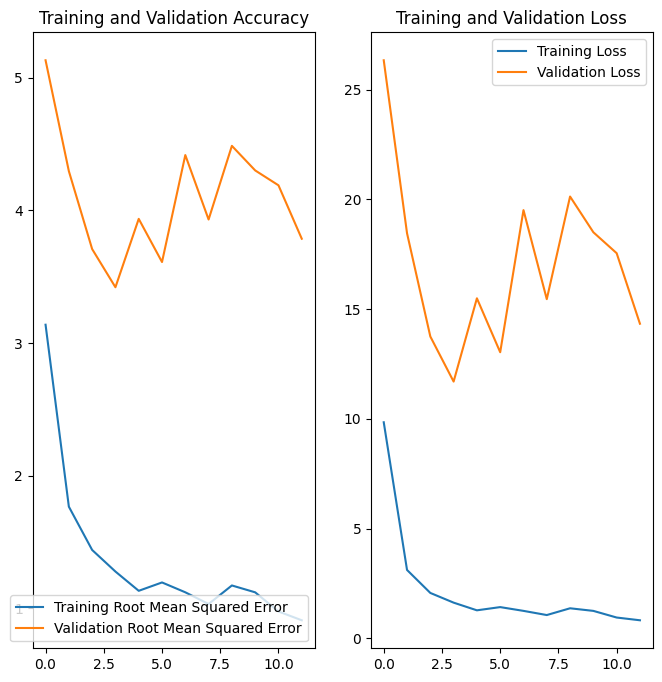

In [ ]:
# code for plotting the results from the model for loss and root mean square error
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2

In [ ]:
model2 = Sequential()
model2.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile model

opt = Adam()
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9344      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model2.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
1133/1137 [============================>.] - ETA: 0s - loss: 28.5530 - root_mean_squared_error: 5.3435 - r2_score: -25.5921
Epoch 1: val_loss improved from inf to 1.49559, saving model to DMSP2_2023-08-1705_05_12.282066/model-00001-28.48773-5.33739-1.49559-1.22294.h5
1137/1137 [==============================] - 11s 7ms/step - loss: 28.4877 - root_mean_squared_error: 5.3374 - r2_score: -25.5423 - val_loss: 1.4956 - val_root_mean_squared_error: 1.2229 - val_r2_score: -0.1281
Epoch 2/100
1133/1137 [============================>.] - ETA: 0s - loss: 4.0627 - root_mean_squared_error: 2.0156 - r2_score: -2.9981
Epoch 2: val_loss improved from 1.49559 to 1.27811, saving model to DMSP2_2023-08-1705_05_12.282066/model-00002-4.05925-2.01476-1.27811-1.13054.h5
1137/1137 [==============================] - 6s 6ms/step - loss: 4.0593 - root_mean_squared_error: 2.0148 - r2_score: -3.0171 - val_loss: 1.2781 - val_root_mean_squared_error: 1.1305 - val_r2_score: 0.0284
Epoch 3/100
1134/1137 [

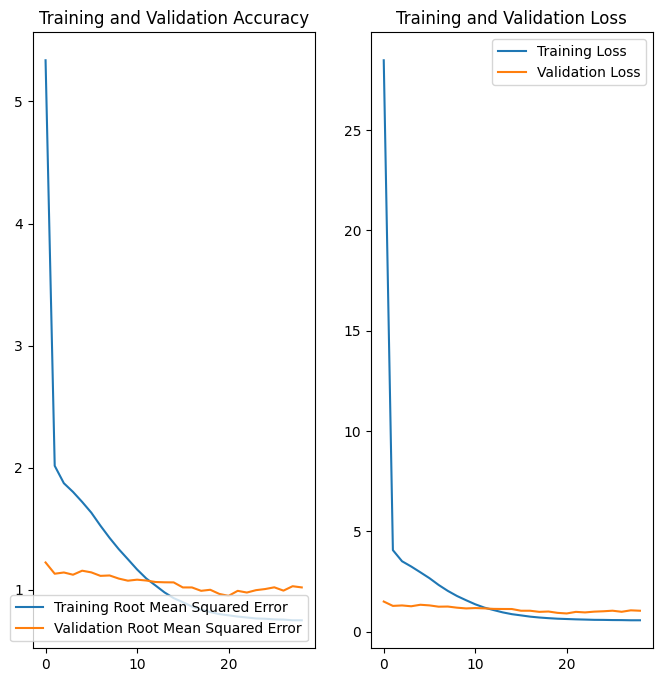

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3

In [ ]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(128, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile model

opt = Adam(0.0001)
model3.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               18688     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model3.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=500, batch_size=512, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
2266/2273 [============================>.] - ETA: 0s - loss: 88.0117 - root_mean_squared_error: 9.3815 - r2_score: -94.1633
Epoch 1: val_loss improved from inf to 64.62692, saving model to DMSP3_2023-08-1705_11_22.831005/model-00001-87.95063-9.37820-64.62692-8.03909.h5
2273/2273 [==============================] - 20s 7ms/step - loss: 87.9506 - root_mean_squared_error: 9.3782 - r2_score: -94.3640 - val_loss: 64.6269 - val_root_mean_squared_error: 8.0391 - val_r2_score: -61.3777
Epoch 2/500
2273/2273 [==============================] - ETA: 0s - loss: 39.8748 - root_mean_squared_error: 6.3146 - r2_score: -41.1202
Epoch 2: val_loss improved from 64.62692 to 11.71974, saving model to DMSP3_2023-08-1705_11_22.831005/model-00002-39.87480-6.31465-11.71974-3.42341.h5
2273/2273 [==============================] - 16s 7ms/step - loss: 39.8748 - root_mean_squared_error: 6.3146 - r2_score: -41.1202 - val_loss: 11.7197 - val_root_mean_squared_error: 3.4234 - val_r2_score: -9.0175
Epoch 3/

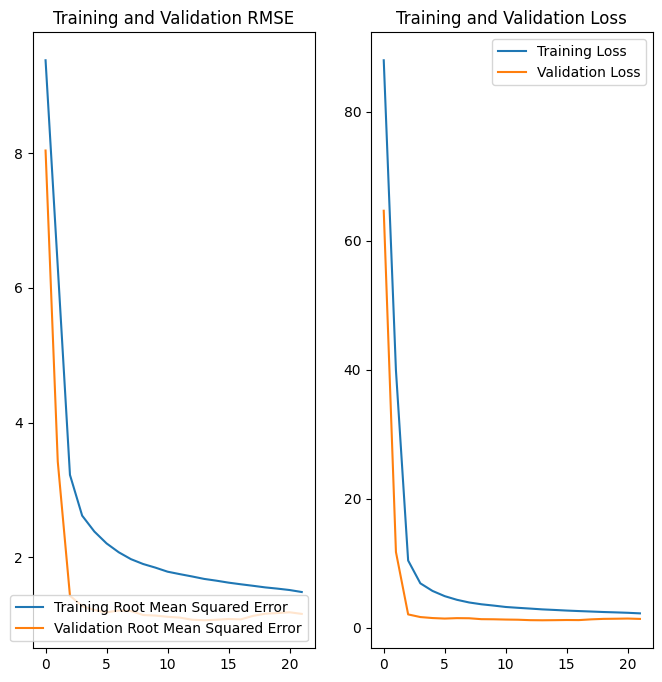

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4

In [ ]:
model4 = Sequential()
model4.add(Dense(512, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(256, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(128, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(64, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(32, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compile model

opt = Adam(0.001)
model4.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               37376     
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)              

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model4.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 95.6236 - root_mean_squared_error: 9.7787 - r2_score: -96.3344
Epoch 1: val_loss improved from inf to 87.48264, saving model to DMSP4_2023-08-1705_19_11.200359/model-00001-95.62355-9.77873-87.48264-9.35322.h5
72/72 [==============================] - 60s 13ms/step - loss: 95.6236 - root_mean_squared_error: 9.7787 - r2_score: -96.3344 - val_loss: 87.4826 - val_root_mean_squared_error: 9.3532 - val_r2_score: -66.1400
Epoch 2/100
68/72 [===========================>..] - ETA: 0s - loss: 86.6497 - root_mean_squared_error: 9.3086 - r2_score: -78.6424
Epoch 2: val_loss improved from 87.48264 to 72.42845, saving model to DMSP4_2023-08-1705_19_11.200359/model-00002-86.25123-9.28715-72.42845-8.51049.h5
72/72 [==============================] - 1s 9ms/step - loss: 86.2512 - root_mean_squared_error: 9.2872 - r2_score: -86.5713 - val_loss: 72.4285 - val_root_mean_squared_error: 8.5105 - val_r2_score: -54.6068
Epoch 3/100
70/72 [====

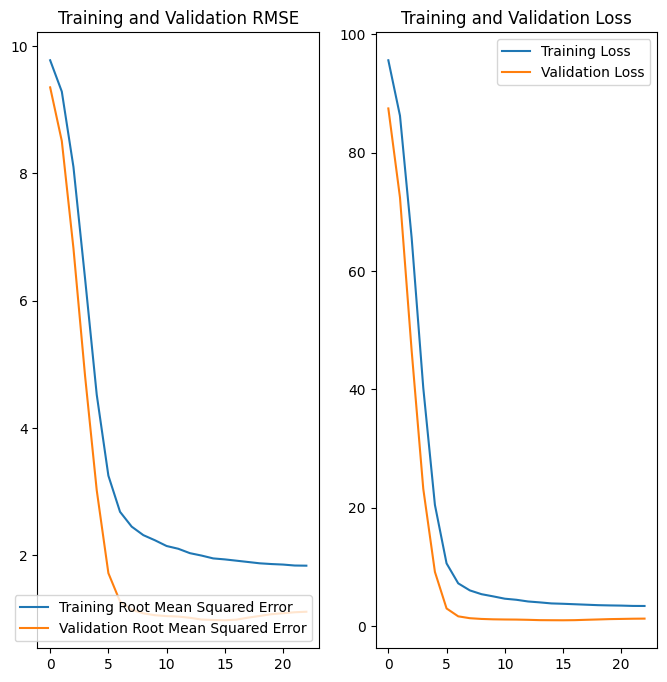

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 5

In [ ]:
model5 = Sequential()
model5.add(Dense(512, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(256, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(128, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(64, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(32, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(16, kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compile model

opt = Adam(0.002)
model5.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               37376     
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)               

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

callbacks_list = [checkpoint, LR, early_stopping]

In [ ]:
history = model5.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
69/72 [===========================>..] - ETA: 0s - loss: 45.9646 - root_mean_squared_error: 6.7797 - r2_score: -39.9619
Epoch 1: val_loss improved from inf to 14.90159, saving model to DMSP5_2023-08-1705_21_50.017059/model-00001-45.29779-6.73036-14.90159-3.86026.h5
72/72 [==============================] - 3s 9ms/step - loss: 45.2978 - root_mean_squared_error: 6.7304 - r2_score: -42.0051 - val_loss: 14.9016 - val_root_mean_squared_error: 3.8603 - val_r2_score: -7.8409 - lr: 0.0020
Epoch 2/100
68/72 [===========================>..] - ETA: 0s - loss: 14.3668 - root_mean_squared_error: 3.7904 - r2_score: -11.9853
Epoch 2: val_loss did not improve from 14.90159
72/72 [==============================] - 0s 5ms/step - loss: 14.5750 - root_mean_squared_error: 3.8177 - r2_score: -12.5497 - val_loss: 18.6974 - val_root_mean_squared_error: 4.3240 - val_r2_score: -10.1667 - lr: 0.0020
Epoch 3/100
70/72 [============================>.] - ETA: 0s - loss: 13.0098 - root_mean_squared_error:

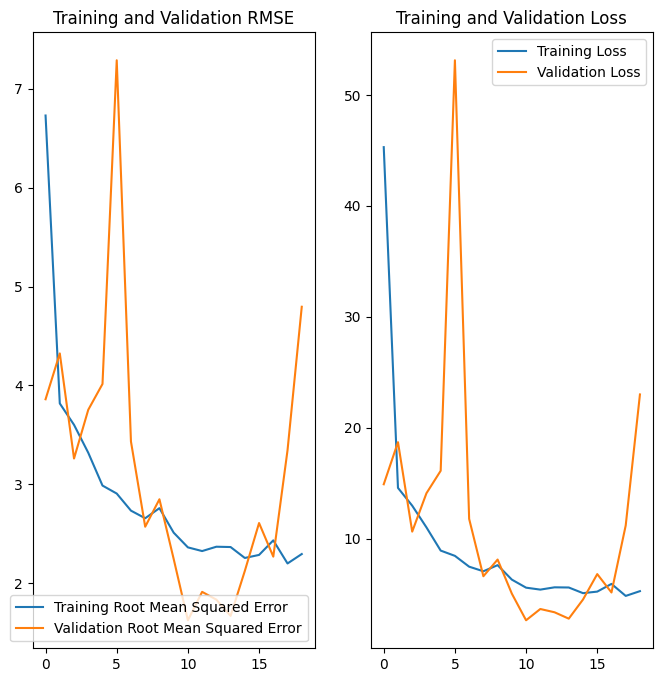

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# as LSTM takes input in a particular format, we reshape the training and validation data
import numpy
train_X = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#train_X = numpy.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
val_X = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

In [ ]:
train_X

array([[[ 0.77130336, -1.54744276,  1.3882614 , ...,  0.25936301,
         -1.5805548 ,  0.43831104]],

       [[ 0.16529422, -1.54744276,  1.38401443, ...,  0.25936301,
         -1.5805548 ,  0.43831104]],

       [[-0.93816164, -1.54744276,  1.37798164, ...,  0.30421923,
         -1.61190527,  0.24033408]],

       ...,

       [[-0.93653692,  2.08967675,  0.04455679, ..., -1.12220872,
          0.41769678,  0.17984112]],

       [[-1.43813971,  2.08967675,  0.05701577, ..., -1.05941   ,
          0.51720044,  0.48230592]],

       [[-1.68800329,  2.08967675,  0.06324354, ..., -1.05941   ,
          0.51720044,  0.48230592]]])

## Model 6

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(Dense(1, activation='linear'))

opt = Adam(0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                35072     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 35,137
Trainable params: 35,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=500, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
63/72 [=========================>....] - ETA: 0s - loss: 87.3093 - root_mean_squared_error: 9.3439 - r2_score: -79.5107
Epoch 1: val_loss improved from inf to 65.64146, saving model to DMSP6_2023-08-1705_23_48.628893/model-00001-85.36888-9.23953-65.64146-8.10194.h5
72/72 [==============================] - 4s 12ms/step - loss: 85.3689 - root_mean_squared_error: 9.2395 - r2_score: -84.7220 - val_loss: 65.6415 - val_root_mean_squared_error: 8.1019 - val_r2_score: -49.2079
Epoch 2/500
64/72 [=========================>....] - ETA: 0s - loss: 56.6150 - root_mean_squared_error: 7.5243 - r2_score: -50.6493
Epoch 2: val_loss improved from 65.64146 to 37.95490, saving model to DMSP6_2023-08-1705_23_48.628893/model-00002-54.90734-7.40995-37.95490-6.16075.h5
72/72 [==============================] - 0s 6ms/step - loss: 54.9073 - root_mean_squared_error: 7.4099 - r2_score: -52.1153 - val_loss: 37.9549 - val_root_mean_squared_error: 6.1608 - val_r2_score: -27.5136
Epoch 3/500
70/72 [=====

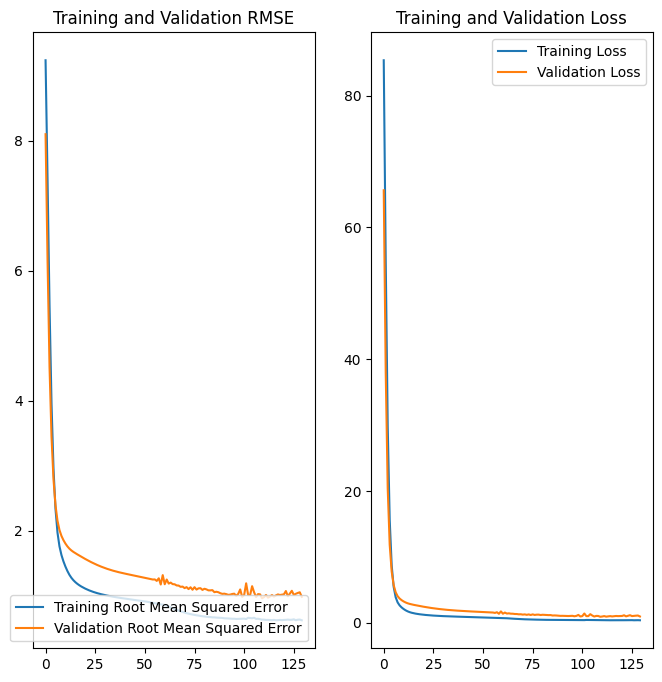

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(130)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 7

In [ ]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(64, activation=k.layers.LeakyReLU(alpha=0.02)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model_lstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               336896    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 353,409
Trainable params: 353,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm2.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=500, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
65/72 [==========================>...] - ETA: 0s - loss: 62.4196 - root_mean_squared_error: 7.9006 - r2_score: -55.4509
Epoch 1: val_loss improved from inf to 12.28558, saving model to DMSP7_2023-08-1705_25_37.240323/model-00001-58.63158-7.65713-12.28558-3.50508.h5
72/72 [==============================] - 4s 16ms/step - loss: 58.6316 - root_mean_squared_error: 7.6571 - r2_score: -52.4220 - val_loss: 12.2856 - val_root_mean_squared_error: 3.5051 - val_r2_score: -8.3043
Epoch 2/500
68/72 [===========================>..] - ETA: 0s - loss: 13.8982 - root_mean_squared_error: 3.7280 - r2_score: -11.6774
Epoch 2: val_loss improved from 12.28558 to 7.25475, saving model to DMSP7_2023-08-1705_25_37.240323/model-00002-13.75421-3.70867-7.25475-2.69346.h5
72/72 [==============================] - 0s 6ms/step - loss: 13.7542 - root_mean_squared_error: 3.7087 - r2_score: -12.5771 - val_loss: 7.2547 - val_root_mean_squared_error: 2.6935 - val_r2_score: -5.0502
Epoch 3/500
65/72 [==========

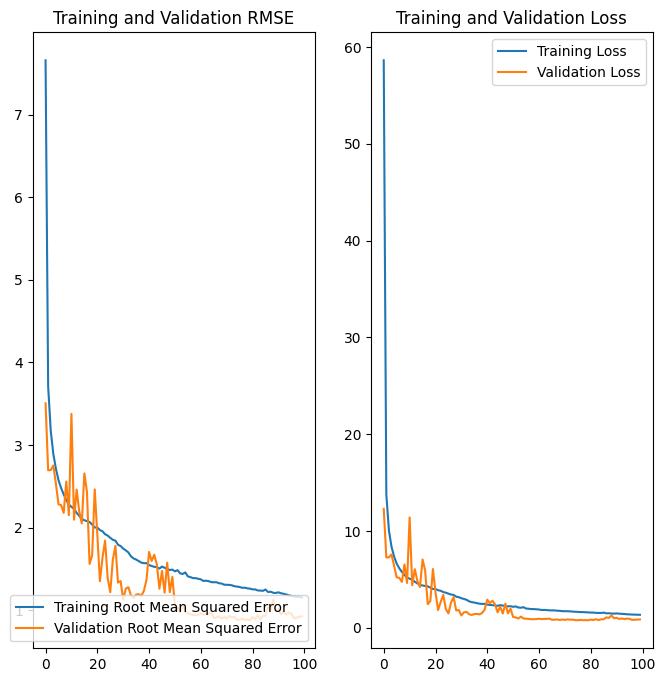

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history2 = model_lstm2.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=500, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
63/72 [=========================>....] - ETA: 0s - loss: 1.3130 - root_mean_squared_error: 1.1459 - r2_score: -0.2070
Epoch 1: val_loss did not improve from 0.75668
72/72 [==============================] - 0s 6ms/step - loss: 1.3185 - root_mean_squared_error: 1.1483 - r2_score: -0.2722 - val_loss: 0.8851 - val_root_mean_squared_error: 0.9408 - val_r2_score: 0.4122
Epoch 2/500
65/72 [==========================>...] - ETA: 0s - loss: 1.3038 - root_mean_squared_error: 1.1418 - r2_score: -0.1979
Epoch 2: val_loss did not improve from 0.75668
72/72 [==============================] - 0s 6ms/step - loss: 1.3095 - root_mean_squared_error: 1.1443 - r2_score: -0.2357 - val_loss: 0.8107 - val_root_mean_squared_error: 0.9004 - val_r2_score: 0.4498
Epoch 3/500
67/72 [==========================>...] - ETA: 0s - loss: 1.2984 - root_mean_squared_error: 1.1395 - r2_score: -0.1891
Epoch 3: val_loss did not improve from 0.75668
72/72 [==============================] - 0s 6ms/step - loss: 1.30

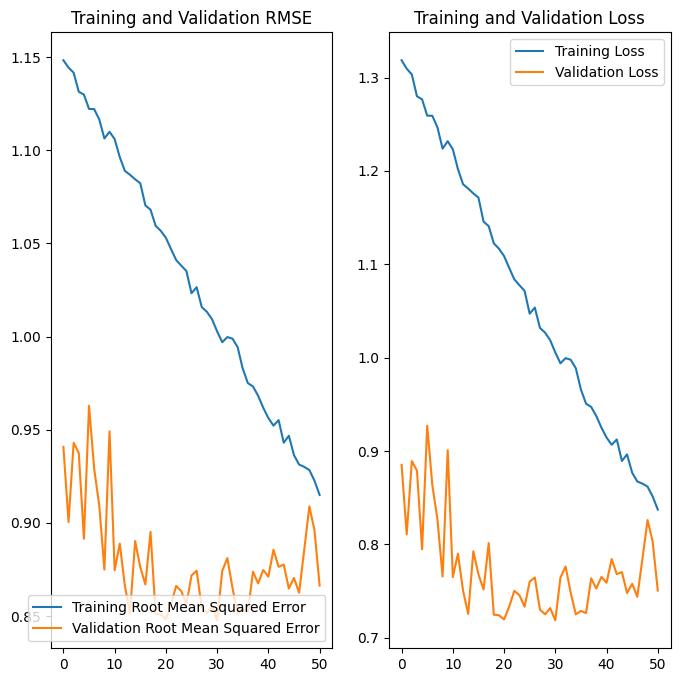

In [ ]:
rmse = history2.history['root_mean_squared_error']
val_rmse = history2.history['val_root_mean_squared_error']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(51)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(128, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(64, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(32, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(16, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(8, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm3.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm3.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=500, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
68/72 [===========================>..] - ETA: 0s - loss: 55.4929 - root_mean_squared_error: 7.4494 - r2_score: -48.8207
Epoch 1: val_loss improved from inf to 15.40315, saving model to DMSP8_2023-08-1705_27_51.843079/model-00001-54.41842-7.37688-15.40315-3.92468.h5
72/72 [==============================] - 5s 14ms/step - loss: 54.4184 - root_mean_squared_error: 7.3769 - r2_score: -51.1369 - val_loss: 15.4031 - val_root_mean_squared_error: 3.9247 - val_r2_score: -13.0851
Epoch 2/500
72/72 [==============================] - ETA: 0s - loss: 23.2294 - root_mean_squared_error: 4.8197 - r2_score: -21.6649
Epoch 2: val_loss improved from 15.40315 to 10.30985, saving model to DMSP8_2023-08-1705_27_51.843079/model-00002-23.22941-4.81969-10.30985-3.21090.h5
72/72 [==============================] - 1s 10ms/step - loss: 23.2294 - root_mean_squared_error: 4.8197 - r2_score: -21.6649 - val_loss: 10.3099 - val_root_mean_squared_error: 3.2109 - val_r2_score: -7.1426
Epoch 3/500
69/72 [=====

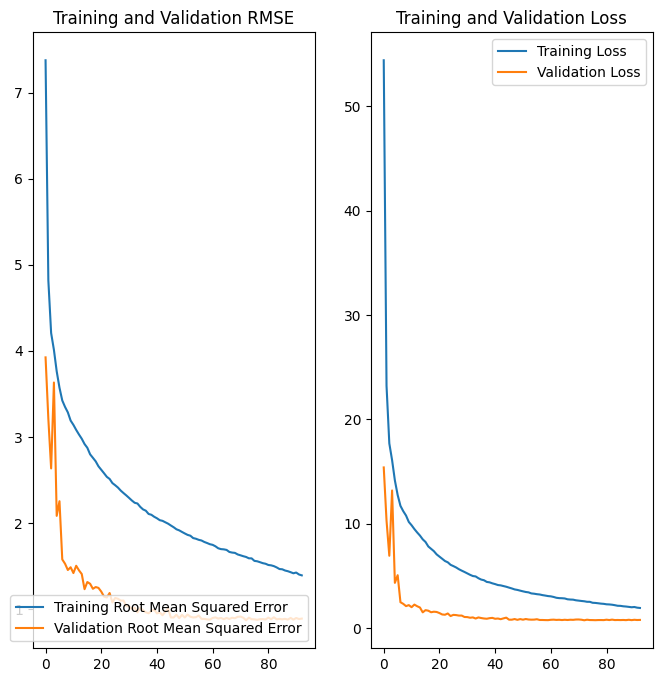

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(93)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Since Model 2 give better result we are saving that model

In [ ]:
model_lstm3.save('models/lstm_model.h5')

In [ ]:
!pip install lime -U

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
idx=np.random.randint(len(X_train_scaled),size=50)
sample=X_train_scaled[idx,:]

In [ ]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(sample, feature_names=X_train.columns.values.tolist(),
                                                   class_names=['ELE_TOTAL_ENERGY_FLUX'], mode='regression')

In [ ]:
exp = explainer.explain_instance(X_train_scaled[52],model2)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp = explainer.explain_instance(X_train_scaled[53],model2)
exp.show_in_notebook(show_table=True)

In [ ]:
exp = explainer.explain_instance(X_train_scaled[109],model2,num_features=10)
exp.show_in_notebook(show_table=True)

In [ ]:
exp = explainer.explain_instance(X_train_scaled[1111],model2)
exp.show_in_notebook(show_table=True)

In [ ]:
exp = explainer.explain_instance(X_train_scaled[3000],model2)
exp.show_in_notebook(show_table=True)

In [ ]:
# exp.as_list()

In [ ]:
selected_features=['sin_SC_AACGM_LTIME', 'PC_6hr', 'SymH_3hr', 'SC_AACGM_LAT', 'Bx', 'By']

In [ ]:
xTrain=X_train[selected_features]
xVal=X_val[selected_features]

scaler = StandardScaler()
scaler = scaler.fit(xTrain.values)
xTrainScaled=scaler.transform(xTrain.values)
xValScaled=scaler.transform(xVal.values)

#Changing for LSTM
train_X_F = xTrainScaled.reshape((xTrainScaled.shape[0], 1, xTrainScaled.shape[1]))
#train_X = numpy.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
val_X_F = xValScaled.reshape((xValScaled.shape[0], 1, xValScaled.shape[1]))

In [ ]:
# X_val = df_val[feature_cols].copy(deep=True)
# y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
# X_train = df_train[feature_cols].copy(deep=True)
# y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
# scaler_X = StandardScaler()
# scaler_X = scaler_X.fit(X_train.values)
# X_val_scaled = scaler_X.transform(X_val.values)
# X_train_scaled = scaler_X.transform(X_train.values)

In [ ]:
model_lstmF = Sequential()
model_lstmF.add(LSTM(256, input_shape=(train_X_F.shape[1], train_X_F.shape[2])))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(128, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(64, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(32, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(16, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(8, activation=k.layers.LeakyReLU(alpha=0.03)))
model_lstmF.add(Dropout(0.25))
model_lstmF.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstmF.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSPF' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstmF.fit(train_X_F, y_train_log, validation_data=(val_X_F, y_val_log), epochs=500, batch_size=1024, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
71/72 [============================>.] - ETA: 0s - loss: 58.8251 - root_mean_squared_error: 7.6698 - r2_score: -51.5914
Epoch 1: val_loss improved from inf to 18.93162, saving model to DMSPF_2023-08-1705_55_33.487195/model-00001-58.82046-7.66945-18.93162-4.35105.h5
72/72 [==============================] - 6s 15ms/step - loss: 58.8205 - root_mean_squared_error: 7.6694 - r2_score: -52.3565 - val_loss: 18.9316 - val_root_mean_squared_error: 4.3510 - val_r2_score: -15.9216
Epoch 2/500
67/72 [==========================>...] - ETA: 0s - loss: 26.3597 - root_mean_squared_error: 5.1342 - r2_score: -23.1706
Epoch 2: val_loss improved from 18.93162 to 10.89645, saving model to DMSPF_2023-08-1705_55_33.487195/model-00002-26.14813-5.11352-10.89645-3.30098.h5
72/72 [==============================] - 1s 8ms/step - loss: 26.1481 - root_mean_squared_error: 5.1135 - r2_score: -25.6253 - val_loss: 10.8964 - val_root_mean_squared_error: 3.3010 - val_r2_score: -7.6393
Epoch 3/500
71/72 [======

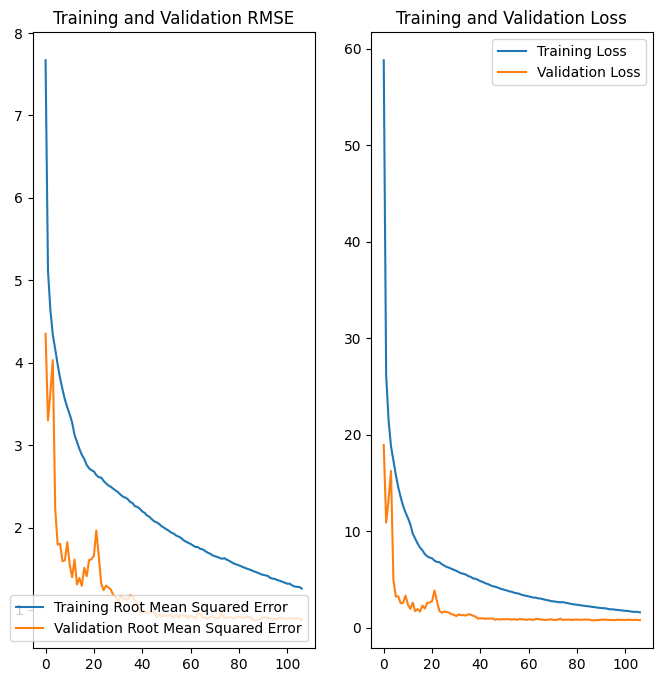

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(107)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_lstmF.save('models/model_lstmF.h5')

In [ ]:
X_train.columns

Index(['SC_AACGM_LAT', 'ID_SC', 'sin_ut', 'cos_ut', 'sin_doy', 'cos_doy',
       'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'F107', 'Bz', 'By', 'Bx',
       'AL', 'AU', 'SymH', 'PC', 'vsw', 'psw', 'Bz_6hr', 'By_6hr', 'Bx_6hr',
       'AL_6hr', 'AU_6hr', 'SymH_6hr', 'PC_6hr', 'vsw_6hr', 'psw_6hr',
       'Bz_3hr', 'By_3hr', 'Bx_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 'PC_3hr',
       'vsw_3hr', 'psw_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AL_1hr', 'AU_1hr',
       'SymH_1hr', 'PC_1hr', 'vsw_1hr', 'psw_1hr', 'Bz_45min', 'By_45min',
       'Bx_45min', 'AL_45min', 'AU_45min', 'SymH_45min', 'PC_45min',
       'vsw_45min', 'psw_45min', 'Bz_30min', 'By_30min', 'Bx_30min',
       'AL_30min', 'AU_30min', 'SymH_30min', 'PC_30min', 'vsw_30min',
       'psw_30min', 'Bz_10min', 'By_10min', 'Bx_10min', 'AL_10min', 'AU_10min',
       'SymH_10min', 'PC_10min', 'vsw_10min', 'psw_10min'],
      dtype='object')